In [1]:
import math
import random

import numpy as np
import tensorflow as tf
import cv2
import os
from collections import Counter
import xml.etree.ElementTree as ET
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

slim = tf.contrib.slim

/nfshome/xueqin/anaconda3/envs/ge/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
sys.path.append('../')

In [5]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [6]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

In [7]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NCHW'#NHWC
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '/nfshome/xueqin/udalearn/shibai/checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '/nfshome/xueqin/udalearn/data/VOCdevkit/result_50/model.ckpt-120000'
# ckpt_filename = '/nfshome/xueqin/udalearn/data/result/result_attover_x_01_an/model.ckpt-100000'

# ckpt_filename = '/nfshome/xueqin/udalearn/BeerData/tmp/logs/old_output/log1/model.ckpt-10455'

isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

==== (1, 3, 300, 300)
INFO:tensorflow:Restoring parameters from /nfshome/xueqin/udalearn/shibai/checkpoints/ssd_300_vgg.ckpt


In [8]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=0.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)#21
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

In [9]:
VOC_LABELS = {
    'none': (0, 'Background'),
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle'),
    'tvmonitor': (20, 'Indoor'),
}

001197.jpg  002446.jpg	003723.jpg  004923.jpg	006194.jpg  007462.jpg	008666.jpg  009931.jpg
001198.jpg  002447.jpg	003724.jpg  004924.jpg	006195.jpg  007463.jpg	008668.jpg  009933.jpg
001202.jpg  002449.jpg	003725.jpg  004925.jpg	006197.jpg  007464.jpg	008669.jpg  009934.jpg
001208.jpg  002451.jpg	003726.jpg  004927.jpg	006199.jpg  007469.jpg	008671.jpg  009936.jpg
001210.jpg  002453.jpg	003728.jpg  004930.jpg	006200.jpg  007471.jpg	008672.jpg  009937.jpg
001213.jpg  002455.jpg	003730.jpg  004932.jpg	006204.jpg  007472.jpg	008673.jpg  009941.jpg
001216.jpg  002457.jpg	003731.jpg  004933.jpg	006205.jpg  007473.jpg	008674.jpg  009943.jpg
001217.jpg  002463.jpg	003733.jpg  004934.jpg	006207.jpg  007476.jpg	008675.jpg  009948.jpg
001218.jpg  002464.jpg	003734.jpg  004937.jpg	006211.jpg  007478.jpg	008677.jpg  009951.jpg
001219.jpg  002467.jpg	003736.jpg  004940.jpg	006213.jpg  007485.jpg	008678.jpg  009952.jpg
001220.jpg  002469.jpg	003737.jpg  004941.jpg	006217.jpg  007487.jpg	008679.jpg  009953.jpg
001222.jpg  002473.jpg	003738.jpg  004942.jpg	006226.jpg  007488.jpg	008681.jpg  009956.jpg
001223.jpg  002474.jpg	003739.jpg  004944.jpg	006227.jpg  007492.jpg	008682.jpg  009957.jpg
001227.jpg  002475.jpg	003741.jpg  004945.jpg	006228.jpg  007494.jpg	008684.jpg  009960.jpg
001228.jpg  002482.jpg	003742.jpg  004947.jpg	006231.jpg  007495.jpg	008685.jpg  009962.jpg
001232.jpg  002484.jpg	003744.jpg  004949.jpg	006232.jpg  007496.jpg	008686.jpg  009963.jpg

[ 2  2 15  2  2 15  2  2 15]
[0.95545506 0.9374395  0.9185413  0.8892215  0.7782788  0.7176904
 0.5719072  0.5619983  0.5340804 ]
[[0.5924635  0.6106107  0.833531   0.7350365 ]
 [0.51127255 0.15898483 0.7509434  0.3148259 ]
 [0.45001626 0.6157934  0.7871537  0.7200821 ]
 [0.5566637  0.3282939  0.7777181  0.4510289 ]
 [0.5660706  0.44609842 0.80171543 0.57017624]
 [0.38784432 0.30759302 0.7208315  0.41145435]
 [0.5588376  0.39333126 0.77453345 0.5126052 ]
 [0.49054414 0.29999518 0.7487026  0.41464245]
 [0.36357132 0.16270413 0.67014384 0.24988525]]


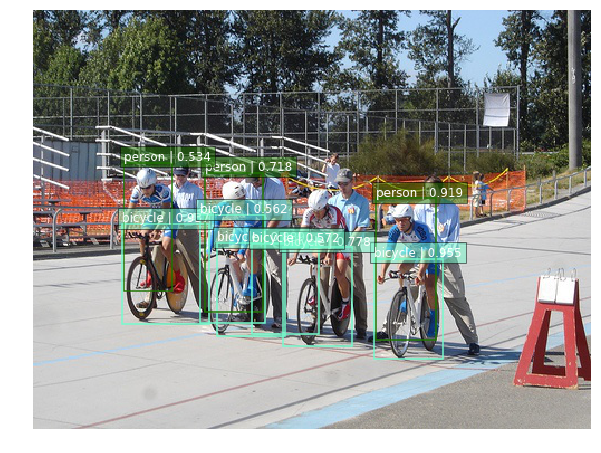

In [220]:

path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/002475.jpg'
img = mpimg.imread(path)
rclasses, rscores, rbboxes = process_image(img)
print(rclasses)
print(rscores)
print(rbboxes)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

[10 10]


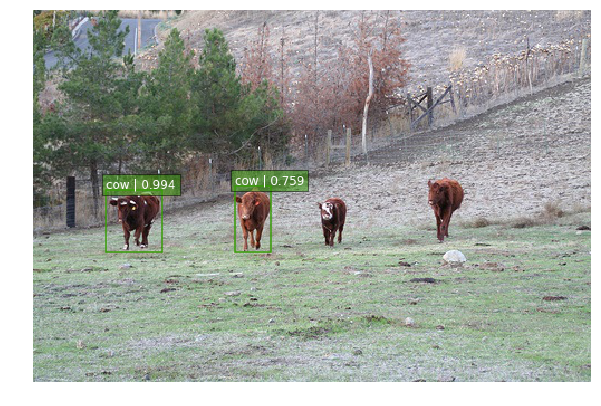

In [11]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/000725.jpg'
# path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/006283.jpg'
# path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/000003.jpg'
img = mpimg.imread(path)
rclasses, rscores, rbboxes =  process_image(img)
print(rclasses)
# print(rscores)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

[20 20 20 20]


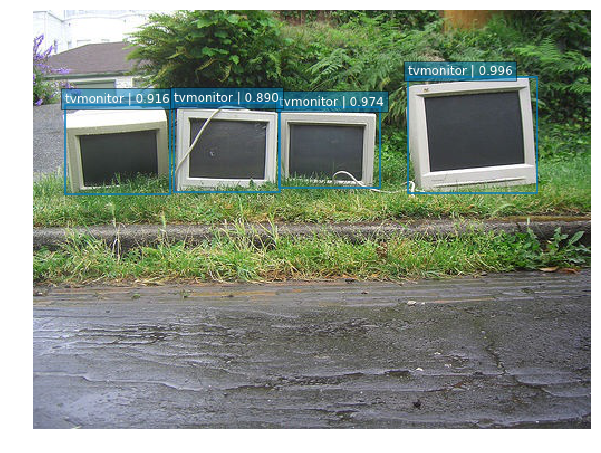

In [12]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/009906.jpg'
## good
# path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/009895.jpg'
# path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/006646.jpg'

img = mpimg.imread(path)
rclasses, rscores, rbboxes = process_image(img)
print(rclasses)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [42]:
# def process_video(path):
#     Thickness = 2

#     img = mpimg.imread(path)
#     rclasses, rscores, rbboxes = process_image(img)
#     #res = visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
#     height = img.shape[0]
#     width = img.shape[1]
#     colors = dict()
#     for i in range(rclasses.shape[0]):
#         cls_id = int(rclasses[i])
#         if cls_id >=0:
#             score = rscores[i]
#             if cls_id not in colors:
#                 colors[cls_id] = (random.random()*255, random.random()*255, random.random()*255)
#                 print("true")
#             ymin = int(rbboxes[i, 0] * height)
#             xmin = int(rbboxes[i, 1] * width)
#             ymax = int(rbboxes[i, 2] * height)
#             xmax = int(rbboxes[i, 3] * width)
#             img=cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[int(cls_id)], Thickness,lineType=8)
#             class_name = str(cls_id)
#             cl = voc_dict[class_name]
#             cv2.putText(img, cl, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[cls_id], thickness=2)
#     return img
# #     plt.imshow('drawimg',img)
# #     return res

# path=r'/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/006634.jpg'
# a=process_video(path)

true


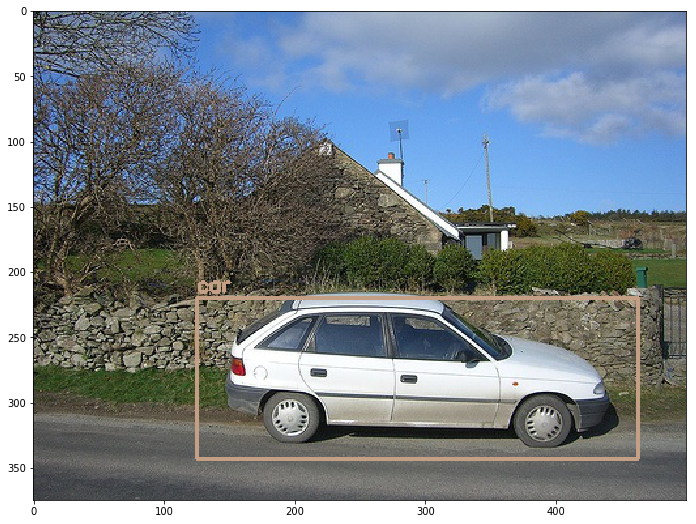

In [43]:
plt.figure(figsize=(16,9))
plt.imshow(a)
plt.show()

[10 10 10 10]


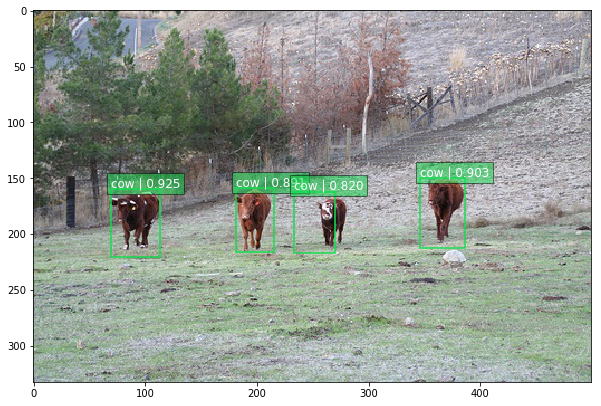

In [28]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/000725.jpg'
# path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/000003.jpg'
img = mpimg.imread(path)
rclasses, rscores, rbboxes =  process_image(img)
print(rclasses)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
#我的att-3的结点

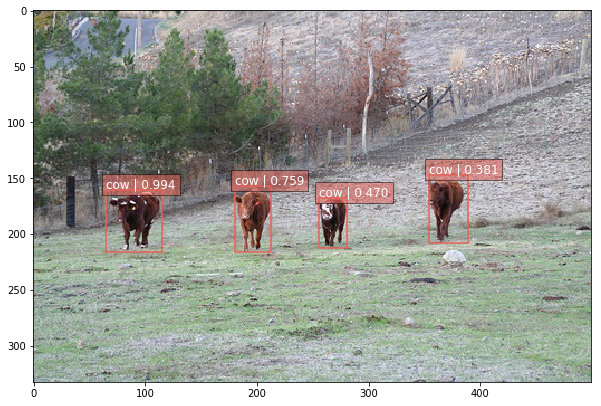

In [14]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/000725.jpg'
# path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/000003.jpg'
img = mpimg.imread(path)
rclasses, rscores, rbboxes =  process_image(img)

visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
#原始结点

In [25]:
path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/1725.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
print(rbboxes)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

FileNotFoundError: [Errno 2] No such file or directory: '/nfshome/xueqin/udalearn/BeerData/JPEGImages/1725.jpg'

In [1]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/006631.jpg'
img = mpimg.imread(path)#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
print(rclasses)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

NameError: name 'mpimg' is not defined

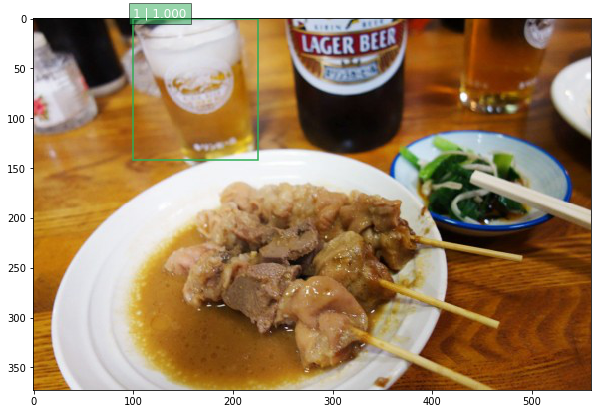

In [48]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/004977.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
#print(type(rclasses), rscores, rbboxes)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

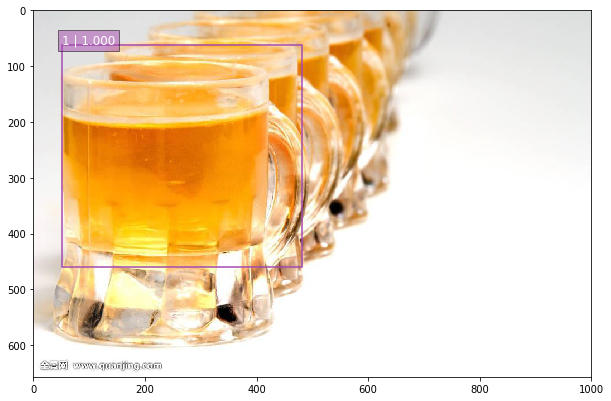

In [38]:
# path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/139.jpg'
path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/Baidu_606.jpeg'
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

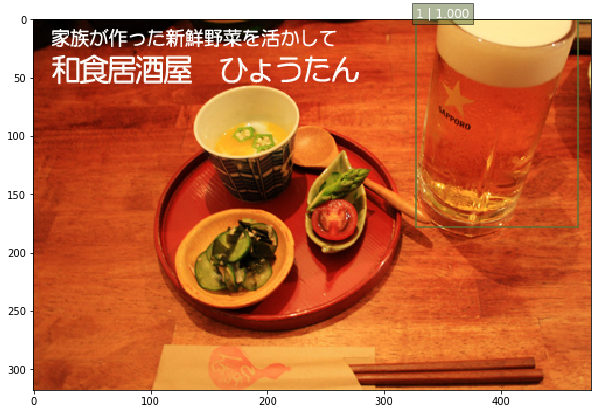

In [39]:
path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/Bing_458.jpeg'
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

[[ 0.41373584  0.41153803  0.75597692  0.73916757]]


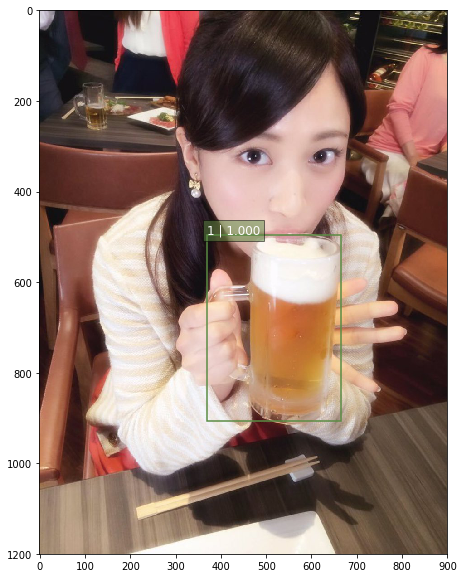

In [43]:
path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/1725.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
print(rbboxes)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

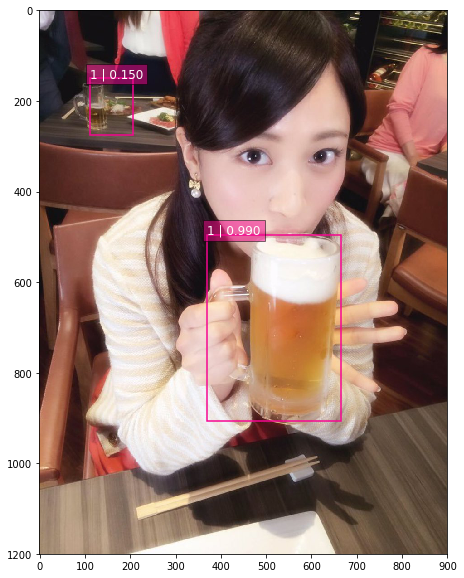

In [69]:
path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/1725.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses=np.array([1,1])
rscores =  np.array([0.15, 0.99])
rbboxes = np.array([[ 0.125,0.123,0.23,0.230245118],
                    [ 0.41373584,0.41153803,0.75597692,0.73916757]])
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)